In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
from pathlib import Path
import pandas as pd

# paths
DATA_ROOT = Path("/content/drive/MyDrive/brainMri")   # original dataset
TO_REMOVE = Path("/content/drive/MyDrive/mavic_project/results/near_duplicates_typeC_to_remove.txt")

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# read removal list
remove_set = set()
if TO_REMOVE.exists():
    remove_set = {line.strip() for line in open(TO_REMOVE) if line.strip()}
print("Duplicates removed from TEST:", len(remove_set))

def count_images(split):
    rows = []
    for cls in CLASSES:
        cdir = DATA_ROOT / split / cls
        if not cdir.exists():
            rows.append([cls, 0])
            continue
        count = 0
        for fname in os.listdir(cdir):
            if not fname.lower().endswith(("png","jpg","jpeg","bmp","tif","tiff")):
                continue
            p = str(cdir / fname)
            if split == "test" and p in remove_set:
                continue
            count += 1
        rows.append([cls, count])
    return rows

train_rows = count_images("train")
test_rows  = count_images("test")

df_train = pd.DataFrame(train_rows, columns=["Class", "Train Count"])
df_test  = pd.DataFrame(test_rows,  columns=["Class", "Test Count"])

df_table1 = pd.merge(df_train, df_test, on="Class")
df_table1["Total"] = df_table1["Train Count"] + df_table1["Test Count"]

df_table1


Duplicates removed from TEST: 425


,Class,Train Count,Test Count,Total
0,glioma,1321,300,1621
1,meningioma,1339,198,1537
2,notumor,1595,93,1688
3,pituitary,1457,295,1752


In [ ]:
!pip -q install --upgrade pip setuptools wheel
!pip -q install torchmetrics==1.4.0.post0 timm==1.0.9 scikit-learn==1.5.2 \
                opencv-python-headless==4.10.0.84 einops==0.8.0 tqdm==4.66.5

import os, sys, torch
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)
try:
    import torch.multiprocessing as mp
    mp.set_start_method("spawn", force=True)
except RuntimeError:
    pass

print("Python:", sys.version)
print("PyTorch:", torch.__version__, "| CUDA:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU-only")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.5 which is incompatible.
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126 | CUDA: 12.6
GPU: NVIDIA A100-SXM4-40GB


In [ ]:

from pathlib import Path

# Dataset: brainMri/{train,test}/{glioma,meningioma,notumor,pituitary}
#DATA_ROOT_DRIVE = Path("/content/drive/MyDrive/brainMri")
USE_LOCAL_COPY = True
DATA_ROOT = Path("/content/drive/MyDrive/brainMri")


PROJECT_ROOT = Path("/content/drive/MyDrive/mavic_project")
for d in ["checkpoints","logs","metrics","figs","cams","predictions","configs","results","profiles","exports","tmp"]:
    (PROJECT_ROOT/d).mkdir(parents=True, exist_ok=True)

expected = [
    DATA_ROOT/"train"/"glioma", DATA_ROOT/"train"/"meningioma", DATA_ROOT/"train"/"notumor", DATA_ROOT/"train"/"pituitary",
    DATA_ROOT/"test"/"glioma",  DATA_ROOT/"test"/"meningioma",  DATA_ROOT/"test"/"notumor",  DATA_ROOT/"test"/"pituitary",
]
missing = [str(p) for p in expected if not p.exists()]
print("All expected folders present." if not missing else f"Missing paths: {missing}")


All expected folders present.


In [ ]:
import random, numpy as np, torch

# ===== Base MaViCNet (Transformer) — your already-trained config =====
BASE_D_MODEL = 192
BASE_NHEAD   = 6
BASE_DEPTH   = 4
BASE_PATCH   = 16
BASE_NUM_CLASSES = 4
BASE_CLASS_NAMES = ["glioma","meningioma","notumor","pituitary"]
BASE_CKPT = PROJECT_ROOT/"checkpoints"/"mavic_best.pt"  # <-- path to your best (epoch 132) checkpoint

# ===== Pretrained backbone variant (ConvNeXt-Base) =====
BACKBONE_NAME = "convnext_base"    # change to "convnext_small" if OOM
PT_D_MODEL    = 256                # head dim after projection
PT_DROPOUT    = 0.20

# ===== Training knobs =====
SEED = 42
IMG_SIZE = 256                     # bump resolution; lower to 224 if OOM
BATCH_SIZE = 20                    # adjust (try 16–24)
NUM_WORKERS = 0                    # safest on Colab Py3.12
GRAD_ACCUM_STEPS = 1
EPOCHS_PT = 50                     # two-phase fine-tune total
WARMUP_EPOCHS = 8                  # freeze backbone first, then unfreeze
LR_WARMUP = 3e-4
LR_FINETUNE = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 8

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

torch.backends.cudnn.benchmark = True
print(f"Device: {DEVICE} | IMG={IMG_SIZE} | BS={BATCH_SIZE} | Base(d={BASE_D_MODEL},h={BASE_NHEAD}) | PT(backbone={BACKBONE_NAME}, d={PT_D_MODEL})")


Device: cuda | IMG=256 | BS=20 | Base(d=192,h=6) | PT(backbone=convnext_base, d=256)


In [ ]:
from glob import glob
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import cv2, torch, numpy as np
from tqdm.auto import tqdm
from pathlib import Path

def to_rgb(img_bgr): return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def apply_hist_equalize(img_rgb):
    he = np.zeros_like(img_rgb)
    for i in range(3): he[:,:,i] = cv2.equalizeHist(img_rgb[:,:,i])
    return he

def apply_CLAHE(img_rgb, clip=2.0, tile=8):
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))
    cl = clahe.apply(l)
    lab = cv2.merge([cl,a,b])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

base_train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor()
])
base_test_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

def normalize_tensor(x):
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    return (x - mean)/std

CLASS_NAMES = BASE_CLASS_NAMES
NUM_CLASSES = BASE_NUM_CLASSES

class BrainMRIDataset(Dataset):
    def __init__(self, root, split="train"):
        self.samples=[]
        self.train = (split=="train")
        for idx, cls in enumerate(CLASS_NAMES):
            cls_dir = Path(root)/split/cls
            files = sorted(glob(str(cls_dir/"**/*"), recursive=True))
            for p in files:
                if p.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
                    self.samples.append((p, idx))

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        path, label = self.samples[i]
        img = cv2.imread(path);
        if img is None: raise RuntimeError(f"Failed to read {path}")
        img = to_rgb(img)

        v1 = img.copy()
        v2 = apply_hist_equalize(img)
        v3 = apply_CLAHE(img)

        tf = base_train_tf if self.train else base_test_tf
        v1 = normalize_tensor(tf(v1))
        v2 = normalize_tensor(tf(v2))
        v3 = normalize_tensor(tf(v3))
        mv = torch.stack([v1, v2, v3], dim=0)  # [V=3, 3, H, W]
        return mv, label, path

def make_loaders(root, bs=BATCH_SIZE):
    train_ds = BrainMRIDataset(root, "train")
    test_ds  = BrainMRIDataset(root, "test")

    counts = np.zeros(len(CLASS_NAMES), dtype=np.int64)
    for _, y in train_ds.samples: counts[y] += 1

    class_weights = 1.0 / np.clip(counts, 1, None)
    sample_weights = [float(class_weights[y]) for _, y in train_ds.samples]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)

    print("✅ Dataset ready | Train:", len(train_ds), " Test:", len(test_ds))
    print("Class counts (train):", {c:int(n) for c,n in zip(CLASS_NAMES, counts)})

    train_loader = DataLoader(train_ds, batch_size=bs, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=False)
    test_loader  = DataLoader(test_ds, batch_size=bs, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)
    return train_loader, test_loader, counts

train_loader, test_loader, class_counts = make_loaders(DATA_ROOT)


✅ Dataset ready | Train: 5712  Test: 1311
Class counts (train): {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


In [ ]:
import os, json, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, brier_score_loss)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:


# Ensure folders exist
for d in ["results","metrics","figs","exports"]:
    (PROJECT_ROOT/d).mkdir(parents=True, exist_ok=True)

def save_plot(path, title, xs, ys, label):
    plt.figure(); plt.plot(xs, ys)
    plt.title(title); plt.xlabel("epoch"); plt.ylabel(label); plt.grid(True)
    plt.savefig(path, dpi=180, bbox_inches='tight'); plt.close()



In [ ]:
from torchvision import transforms
tta_transforms = [
    transforms.Lambda(lambda x: x),
    transforms.Lambda(lambda x: torch.flip(x, dims=[-1])),  # horizontal flip
]


In [ ]:
import timm

PT_BACKBONE = "convnext_base"   # switch to "convnext_small" if OOM
PT_D_MODEL  = 256               # projection dim for the global path
PT_DROPOUT  = 0.20
PT_BEST_CKPT = PROJECT_ROOT/"checkpoints"/"mavic_pt_best.pt"

# --- Shared blocks reused ---
class MSConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, drop=0.1):
        super().__init__()
        self.conv3 = nn.Conv2d(in_ch, out_ch//2, 3, padding=1)
        self.conv5 = nn.Conv2d(in_ch, out_ch//4, 5, padding=2)
        self.conv7 = nn.Conv2d(in_ch, out_ch - (out_ch//2 + out_ch//4), 7, padding=3)
        self.bn = nn.BatchNorm2d(out_ch); self.act = nn.ReLU(inplace=True)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_ch, out_ch//8, 1), nn.ReLU(True),
            nn.Conv2d(out_ch//8, out_ch, 1), nn.Sigmoid()
        )
        self.drop = nn.Dropout2d(drop); self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        x = torch.cat([self.conv3(x), self.conv5(x), self.conv7(x)], dim=1)
        x = self.act(self.bn(x)); x = x*self.se(x); x = self.drop(x)
        return self.pool(x)

class CNNPath(nn.Module):
    def __init__(self, in_ch=3, dims=(64,128,192), out_dim=PT_D_MODEL):
        super().__init__()
        c = in_ch; blocks=[]
        for d in dims:
            blocks += [MSConvBlock(c, d)]
            c = d
        self.blocks = nn.Sequential(*blocks)
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(c, out_dim))
    def forward(self, x): return self.head(self.blocks(x))

class CPAF(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gate = nn.Sequential(nn.Linear(dim*2, dim), nn.ReLU(True), nn.Linear(dim, 2), nn.Softmax(dim=-1))
        self.out  = nn.Linear(dim*2, dim)
    def forward(self, f_cnn, f_glob):
        w = self.gate(torch.cat([f_cnn, f_glob], dim=-1))   # [B,2]
        f = torch.stack([f_cnn, f_glob], dim=1)             # [B,2,D]
        fused = (w.unsqueeze(-1)*f).sum(dim=1)              # [B,D]
        return self.out(torch.cat([fused, fused], dim=-1))  # [B,D]

class ViewAttention(nn.Module):
    def __init__(self, dim, views=3):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(views))
    def forward(self, feats):          # [B,V,D]
        w = F.softmax(self.alpha, dim=0).view(1,-1,1)
        return (feats * w).sum(dim=1)

class GlobalPathPretrained(nn.Module):
    def __init__(self, in_ch, d_model, backbone='convnext_base'):
        super().__init__()
        self.bb = timm.create_model(backbone, pretrained=True, in_chans=in_ch, num_classes=0, global_pool='avg')
        self.proj = nn.Linear(self.bb.num_features, d_model)
    def forward(self, x):
        return self.proj(self.bb(x))

class MaViCNetPT(nn.Module):
    def __init__(self, num_classes, d_model, backbone='convnext_base', head_dropout=PT_DROPOUT):
        super().__init__()
        self.cnn  = CNNPath(in_ch=3, dims=(64,128,192), out_dim=d_model)
        self.glob = GlobalPathPretrained(in_ch=3, d_model=d_model, backbone=backbone)
        self.cpaf = CPAF(dim=d_model)
        self.view = ViewAttention(dim=d_model, views=3)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 256), nn.ReLU(True), nn.Dropout(head_dropout),
            nn.Linear(256, num_classes)
        )
    def forward(self, mv):
        feats=[]
        for v in range(mv.size(1)):
            x = mv[:,v]
            feats.append(self.cpaf(self.cnn(x), self.glob(x)))
        g = self.view(torch.stack(feats, dim=1))
        return self.head(g)

# Instantiate & load best
pt_model = MaViCNetPT(num_classes=NUM_CLASSES, d_model=PT_D_MODEL, backbone=PT_BACKBONE).to(DEVICE)
pt_model.load_state_dict(torch.load(PT_BEST_CKPT, map_location=DEVICE))
pt_model.eval()
print("Loaded PT best:", PT_BEST_CKPT)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Loaded PT best: /content/drive/MyDrive/mavic_project/checkpoints/mavic_pt_best.pt


In [ ]:
# ====== CONFIG ======
from pathlib import Path

# TODO: point to your ORIGINAL dataset root (not the cleaned copy)
DATA_ROOT = Path("/content/drive/MyDrive/brainMri")
TO_REMOVE = Path("/content/drive/MyDrive/mavic_project/results/near_duplicates_typeC_to_remove.txt")

CLASSES = ['glioma','meningioma','notumor','pituitary']  # keep your class order

# Read the removal list (425 flagged)
to_remove = set()
if TO_REMOVE.exists():
    to_remove = {line.strip() for line in TO_REMOVE.open() if line.strip()}
print(f"Excluding {len(to_remove)} test images flagged as cross-split near-duplicates.")

# Build clean test file list
test_files, test_labels = [], []
for c in CLASSES:
    for p in (DATA_ROOT/'test'/c).rglob("*"):
        if p.suffix.lower() in ('.png','.jpg','.jpeg','.bmp','.tif','.tiff'):
            if str(p) not in to_remove:
                test_files.append(str(p))
                test_labels.append(c)

print(f"Clean test size: {len(test_files)}")
# Peek a few
test_files[:3], test_labels[:3]


Excluding 425 test images flagged as cross-split near-duplicates.
Clean test size: 886


(['/content/drive/MyDrive/brainMri/test/glioma/Te-glTr_0003.jpg',
  '/content/drive/MyDrive/brainMri/test/glioma/Te-glTr_0001.jpg',
  '/content/drive/MyDrive/brainMri/test/glioma/Te-glTr_0005.jpg'],
 ['glioma', 'glioma', 'glioma'])

In [ ]:
from pathlib import Path
import os, torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# Paths
DATA_ROOT = Path("/content/drive/MyDrive/brainMri")  # original dataset (NOT cleaned)
TO_REMOVE = Path("/content/drive/MyDrive/mavic_project/results/near_duplicates_typeC_to_remove.txt")

CLASSES   = ['glioma','meningioma','notumor','pituitary']
IMG_SIZE  = 256
BATCH_SIZE = 32
NUM_VIEWS = 3    # this MUST match the views=3 used in ViewAttention

# read removal list (test images to skip)
to_remove = set()
if TO_REMOVE.exists():
    to_remove = {line.strip() for line in TO_REMOVE.open() if line.strip()}
print("Skip in TEST:", len(to_remove), "files")

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(lambda img: img.convert("RGB")),   # force RGB
    transforms.ToTensor(),                                # -> [3,H,W]
    transforms.Normalize(mean=(0.485,0.456,0.406),
                         std=(0.229,0.224,0.225)),
])

class MultiViewDataset(Dataset):
    def __init__(self, root, split="test", classes=None, transform=None,
                 num_views=3, exclude_set=None):
        self.root = Path(root) / split
        self.classes = classes or []
        self.transform = transform
        self.num_views = num_views
        self.exclude = exclude_set or set()
        self.samples = []

        for ci, c in enumerate(self.classes):
            cdir = self.root / c
            if not cdir.exists():
                continue
            for n in os.listdir(cdir):
                if n.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
                    p = str(cdir / n)
                    if p in self.exclude:      # <--- skip near-duplicate test image
                        continue
                    self.samples.append((p, ci))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = Image.open(p).convert("RGB")
        views = []
        for _ in range(self.num_views):
            x = self.transform(img) if self.transform else transforms.ToTensor()(img)
            # x must be [3,H,W]
            if x.ndim != 3 or x.shape[0] != 3:
                raise RuntimeError(f"Bad tensor shape {tuple(x.shape)} for {p}, expected [3,H,W]")
            views.append(x)
        mv = torch.stack(views, dim=0)    # [V,3,H,W]
        return mv, y, p

def get_test_loader_256(root, bs=32, num_workers=2, exclude_set=None):
    ds = MultiViewDataset(root, "test", classes=CLASSES, transform=test_transform,
                          num_views=NUM_VIEWS, exclude_set=exclude_set)
    dl = DataLoader(ds, batch_size=bs, shuffle=False,
                    num_workers=num_workers, pin_memory=True)
    return dl, ds

test_loader, test_ds = get_test_loader_256(DATA_ROOT, bs=BATCH_SIZE,
                                           num_workers=0, exclude_set=to_remove)
print("Clean TEST size (after skipping duplicates):", len(test_ds))

# sanity
mv, yb, pb = next(iter(test_loader))
print("Batch shape from loader (expect [B,V,3,256,256]):", mv.shape)
print("First path:", pb[0])


Skip in TEST: 425 files
Clean TEST size (after skipping duplicates): 886
Batch shape from loader (expect [B,V,3,256,256]): torch.Size([32, 3, 3, 256, 256])
First path: /content/drive/MyDrive/brainMri/test/glioma/Te-glTr_0003.jpg


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
PT_BEST_CKPT = "/content/drive/MyDrive/mavic_project/checkpoints/mavic_pt_best.pt"#change to your checkpoint location
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pt_model = MaViCNetPT(
    num_classes=NUM_CLASSES,
    d_model=PT_D_MODEL,
    backbone=PT_BACKBONE,
    head_dropout=PT_DROPOUT
).to(DEVICE)

state = torch.load(PT_BEST_CKPT, map_location=DEVICE)
pt_model.load_state_dict(state)
pt_model.eval()

#pt_model = MaViCNetPT(NUM_CLASSES, PT_D_MODEL, PT_BACKBONE).to(DEVICE)
#state = torch.load(CKPT_PATH, map_location=DEVICE)
# Make sure pt_model exists and is on device
# (from your earlier cell; if needed, re-run that definition + load)
#pt_model = pt_model.to(DEVICE).eval()

@torch.no_grad()
def eval_mavic_pt(model, loader):
    all_probs, all_y = [], []
    for mv, y, _ in loader:
        # mv: [B,V,3,H,W]  <-- exactly what MaViCNetPT expects
        mv = mv.to(DEVICE, non_blocking=True)
        logits = model(mv)                 # [B, num_classes]
        probs = F.softmax(logits, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_y.append(y.numpy())
    probs = np.concatenate(all_probs, axis=0)
    y_true = np.concatenate(all_y, axis=0)
    y_pred = probs.argmax(1)
    return probs, y_true, y_pred

probs, y_true, y_pred = eval_mavic_pt(pt_model, test_loader)
print("probs:", probs.shape, " y_true:", y_true.shape)


probs: (886, 4)  y_true: (886,)


[CLEAN-TEST] MaViC-PTNet → acc 0.9932 | f1 0.9925 | auc 0.9998


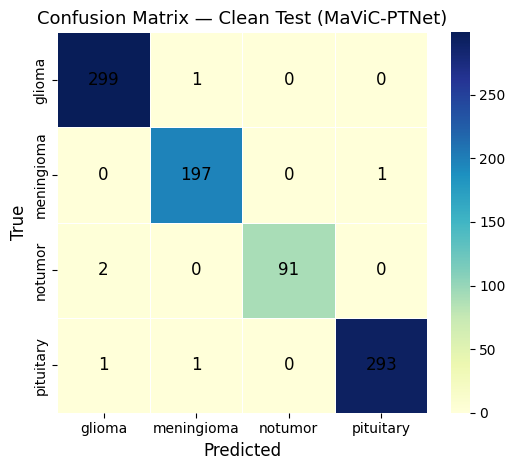

In [ ]:
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')

# macro-AUC
y_true_oh = label_binarize(y_true, classes=list(range(len(CLASSES))))
try:
    macro_auc = roc_auc_score(y_true_oh, probs, average='macro', multi_class='ovr')
except ValueError:
    macro_auc = float("nan")

print(f"[CLEAN-TEST] MaViC-PTNet → acc {acc:.4f} | f1 {macro_f1:.4f} | auc {macro_auc:.4f}")

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
plt.figure(figsize=(5.4, 4.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True,
            linewidths=0.6, linecolor='white',
            annot_kws={"size": 12, "color": "black"},
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix — Clean Test (MaViC-PTNet)", fontsize=13)
plt.tight_layout()
plt.show()
